Le but de ce travail est montrer à quel point la partie features engineering est très importante. 

Ici, Notre base donnée concernent l'historique des appels d'un service d'assurance.
Nous disposons du numéro d'identificaton,  du numéro de telephone,  la date de l'appel.

Un client peut nous appeler plusieurs fois jusqu'à ce que ses doléances soient prises en comptes.

Pour des modèles de types supervisés, nous devrons nous raméné une dimension temporelle ou à une dimensions individuelle.

Par Un client qui a appelé  plusieurs fois le memes jours a surement un problème urgent à regler. 

L'Objectif de ce feature engineeringe est de calculer des métriques qui nous permettrons de resumer l'information de chaque client afin  par la suite  de mettre en place des actions proactives et améliorer l'expérience client.
 
Nous allons nous focaliser ici sur la dimension indivuelle.

# Initialisation du context Spark et Hive

In [1]:
from pyspark import SparkContext, HiveContext, SparkConf 
conf = SparkConf().setMaster('local[*]')                # setMaster('yarn-client')
conf = conf.setAppName('my_second_app')
conf =  conf.set('spark.ui.port', '5050')               # definition du uri spark
conf= conf.set('spark.sql.shuffle.partitions','4')
sc = SparkContext(conf=conf)                            # Instanciation du context spark
hctx = HiveContext(sc)                                # Instanciation du context hive

# Les données

In [2]:
hctx.sql("USE Upec_2022")
df = hctx.sql("SELECT cast(callid as varchar), callnumber ,  product, calldate ,calltime, callqueue FROM svi_data")
rdd = df.rdd                             # transformation en  rdd
rdd.persist()                            # persister les données
df.show(5)

+---------+----------+-------+----------+-------------------+---------+
|   callid|callnumber|product|  calldate|           calltime|callqueue|
+---------+----------+-------+----------+-------------------+---------+
|142267976|    Others|    ULL|25/03/2007|25/03/2007 23:59:58|  3551419|
|169922353| Technique|    WHS|25/03/2007|25/03/2007 23:59:03|  3551427|
|565759195| Technique|    WHS|25/03/2007|25/03/2007 23:56:46|  3551425|
|169245081| Technique|    ULL|25/03/2007|25/03/2007 23:28:09|  3551316|
|493556244| Technique|    ULL|25/03/2007|25/03/2007 23:27:03|  3551317|
+---------+----------+-------+----------+-------------------+---------+
only showing top 5 rows



In [3]:
df.count()

107875

Explorons les données par heure

In [4]:
hdata = rdd.map(lambda x : (x.calltime[:13],1)).groupByKey().mapValues(lambda x : len(list(x))).sortByKey(ascending=False)
hdata.take(5)

[(u'25/03/2007 23', 83),
 (u'25/03/2007 22', 241),
 (u'25/03/2007 21', 585),
 (u'25/03/2007 20', 672),
 (u'25/03/2007 19', 723)]

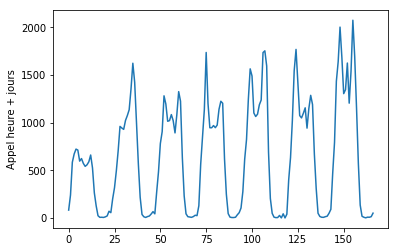

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.ylabel("Appel heure + jours")
plt.plot(hdata.values().collect());

In [6]:
rdd.first()

Row(callid=u'142267976', callnumber=u'Others', product=u'ULL', calldate=u'25/03/2007', calltime=u'25/03/2007 23:59:58', callqueue=3551419)

# EDA

## Vérification des formats des données

In [7]:
print rdd.map(lambda x: x.asDict()['calldate']).first()

25/03/2007


In [8]:
rdd.map(lambda x: (len(str(x.asDict()['calldate'])), 1)).groupByKey().map(lambda x: (x[0], len(list(x[1])))).first()

(10, 107875)

Créer un dictionnaire avec clé = colonne et valeur = taille du contenue de la colonne

In [9]:
for i in df.columns:
    print df.rdd.map(lambda x : (len(str(x.asDict()[i])),1)).groupByKey()\
    .map(lambda x : (i,x[0],len(list(x[1])))).collect()

[('callid', 9, 107328), ('callid', 1, 547)]
[('callnumber', 9, 69924), ('callnumber', 6, 37951)]
[('product', 3, 107875)]
[('calldate', 10, 107875)]
[('calltime', 10, 1), ('calltime', 19, 107874)]
[('callqueue', 7, 107875)]


**Il semble avoir un problème dans la colonne callnumber!!!**

In [10]:
df.columns[0]

'callid'

## Filtres et identifications des ménaces

Nous pouvons faire les filtres sur les dataframes, ou sur les RDD ou encore des filtre de type SQL avec hive

In [11]:
# via df
df.filter('length(calltime)=19').show(5)

+---------+----------+-------+----------+-------------------+---------+
|   callid|callnumber|product|  calldate|           calltime|callqueue|
+---------+----------+-------+----------+-------------------+---------+
|142267976|    Others|    ULL|25/03/2007|25/03/2007 23:59:58|  3551419|
|169922353| Technique|    WHS|25/03/2007|25/03/2007 23:59:03|  3551427|
|565759195| Technique|    WHS|25/03/2007|25/03/2007 23:56:46|  3551425|
|169245081| Technique|    ULL|25/03/2007|25/03/2007 23:28:09|  3551316|
|493556244| Technique|    ULL|25/03/2007|25/03/2007 23:27:03|  3551317|
+---------+----------+-------+----------+-------------------+---------+
only showing top 5 rows



In [12]:
df.filter('length(calltime)=10').show(5)

+---------+----------+-------+----------+----------+---------+
|   callid|callnumber|product|  calldate|  calltime|callqueue|
+---------+----------+-------+----------+----------+---------+
|388320927| Technique|    ULL|21/03/2007|21/03/2007|  3551316|
+---------+----------+-------+----------+----------+---------+



**Nous dévons par la suite reformater la date !!!!!!!!!**

In [13]:
df.filter('length(callid)=1').show(5)

+------+----------+-------+----------+-------------------+---------+
|callid|callnumber|product|  calldate|           calltime|callqueue|
+------+----------+-------+----------+-------------------+---------+
|     0| Technique|    WHS|25/03/2007|25/03/2007 21:56:36|  3551425|
|     0| Technique|    WHS|25/03/2007|25/03/2007 21:56:20|  3551324|
|     0| Technique|    WHS|25/03/2007|25/03/2007 21:54:13|  3551328|
|     0| Technique|    WHS|25/03/2007|25/03/2007 20:23:33|  3551426|
|     0| Technique|    WHS|25/03/2007|25/03/2007 19:46:01|  3551327|
+------+----------+-------+----------+-------------------+---------+
only showing top 5 rows



In [14]:
# Via rdd
rdd.filter(lambda x : len(x[0])==1).take(3)

[Row(callid=u'0', callnumber=u'Technique', product=u'WHS', calldate=u'25/03/2007', calltime=u'25/03/2007 21:56:36', callqueue=3551425),
 Row(callid=u'0', callnumber=u'Technique', product=u'WHS', calldate=u'25/03/2007', calltime=u'25/03/2007 21:56:20', callqueue=3551324),
 Row(callid=u'0', callnumber=u'Technique', product=u'WHS', calldate=u'25/03/2007', calltime=u'25/03/2007 21:54:13', callqueue=3551328)]

In [15]:
# via hive sql
hctx.sql("SELECT * FROM svi_data where length(cast(callid as varchar))=1").show(5)

+----------+-------------------+---------+-------+----------+------+
|  calldate|           calltime|callqueue|product|callnumber|callid|
+----------+-------------------+---------+-------+----------+------+
|25/03/2007|25/03/2007 21:56:36|  3551425|    WHS| Technique|     0|
|25/03/2007|25/03/2007 21:56:20|  3551324|    WHS| Technique|     0|
|25/03/2007|25/03/2007 21:54:13|  3551328|    WHS| Technique|     0|
|25/03/2007|25/03/2007 20:23:33|  3551426|    WHS| Technique|     0|
|25/03/2007|25/03/2007 19:46:01|  3551327|    WHS| Technique|     0|
+----------+-------------------+---------+-------+----------+------+
only showing top 5 rows



**Il y a un problème au  de callid. Tous les identifiants raménés à 0 sont des clients qu'on ne peut plus rétrouver. A supprimer!!!!**

## Functions et formattage de date

In [16]:
def datformat(v):
    dp = str(v).split(' ')
    if len(dp)==2:
        tp = dp[1]
    else:
        tp = '00:00:00'
    delt = dp[0].split('/')
    return delt[2]+'-'+delt[1]+'-'+delt[0]+' '+tp

### 1ière méthode avec RDD

In [17]:
rdd.map(lambda x : (datformat(x[3]),x[3])).take(5)

[('2007-03-25 00:00:00', u'25/03/2007'),
 ('2007-03-25 00:00:00', u'25/03/2007'),
 ('2007-03-25 00:00:00', u'25/03/2007'),
 ('2007-03-25 00:00:00', u'25/03/2007'),
 ('2007-03-25 00:00:00', u'25/03/2007')]

In [18]:
# 2ième méthode avec Hive SQL

In [19]:
from pyspark.sql.types import *
# Sauvegarder la fonction dans le SPARKSQL
hctx.registerFunction("DateFormat", lambda x : datformat(x), StringType())

In [20]:
# We can define a Unix timestamp as the number of seconds that have passed since '1970-01-01 00:00:00'UTr
rdd2 = hctx.sql("SELECT callid ,COLLECT_LIST(UNIX_TIMESTAMP(DateFormat(calltime))) as call_time \
                FROM svi_data WHERE length(cast(callid as varchar)) !=0 GROUP BY callid")

In [21]:
hctx.sql("SELECT calltime, DateFormat(calltime) as calltime_formated, \
            UNIX_TIMESTAMP(DateFormat(calltime)) as calltime_UNIX_TIMESTAMP FROM svi_data").show(3)

+-------------------+-------------------+-----------------------+
|           calltime|  calltime_formated|calltime_UNIX_TIMESTAMP|
+-------------------+-------------------+-----------------------+
|25/03/2007 23:59:58|2007-03-25 23:59:58|             1174859998|
|25/03/2007 23:59:03|2007-03-25 23:59:03|             1174859943|
|25/03/2007 23:56:46|2007-03-25 23:56:46|             1174859806|
+-------------------+-------------------+-----------------------+
only showing top 3 rows



# Features Engineering Grave à la regression linéaire

Création d'une fonction qui nous permettra de calculer le temps entre des séquences d'appels

In [22]:
import numpy as np
def sortDif(seq):
    seq.sort()
    return np.diff(seq)

In [24]:
rdd2.filter('SIZE(call_time)>=3').count()

11286

In [26]:
rdd2.first()

Row(callid=123456789, call_time=[1174666698, 1174663568, 1174571223, 1174405832])

Definir une fonctions qui fait une regression individuelles et recuperer la pente, la constante 
et d'autres statistique importante

In [27]:
from scipy import stats

def trend(x):
    y=np.arange(1, len(x)+1)
    trend, intercept, r_value, p_value ,std_error= stats.linregress(y,x)
    return (trend, intercept, r_value, p_value, std_error)

In [28]:
trend([165391,  92345,   3130])

(-81130.5,
 249216.33333333331,
 -0.99834913979293449,
 0.03658558764487789,
 4667.5882512635535)

La constante represente la fréquence initial à la quelle le client appelait. 

La pente est positive veut dire que le client appèle de plus en plus.

On se retrouvent avec 5 nouvelles métriques qui sont très informatives Elles pourraient etre utiliser par la suite pour la modélisation du comportement de nos clients 

In [29]:
rdd3 = rdd2.filter('SIZE(call_time) >= 3')\
.rdd.map(lambda x: (x[0], len(x[1]), sortDif((x[1]))))\
.map(lambda x: (x[0], x[1], trend(x[2])))

In [30]:
rdd_fin = hctx.createDataFrame(rdd3.map(lambda x: (x[0], x[1], float(x[2][0]),  float(x[2][1]),  float(x[2][2]),  float(x[2][3]), float(x[2][4]))), ["callid", "nbcall", "pente", "const", "pvalue", "rsquared", "stderr"])

rdd_fin.show()

+---------+------+-------------------+------------------+--------------------+-------------------+------------------+
|   callid|nbcall|              pente|             const|              pvalue|           rsquared|            stderr|
+---------+------+-------------------+------------------+--------------------+-------------------+------------------+
|123456789|     4|           -81130.5| 249216.3333333333| -0.9983491397929345|0.03658558764487789|4667.5882512635535|
|130218478|     5|           132507.4|         -218634.0|  0.7722502890322219| 0.2277497109677779| 77082.98077734151|
|130221240|     9| -5644.428571428572| 68703.92857142858|-0.21299008495125576|  0.612557028023451|10570.698767708865|
|130221732|     4|            40380.0| 87510.33333333334|  0.1820389968189061| 0.8834605757419596|218114.27144580276|
|130253787|     3|             -587.0|            2518.0|                -1.0|                0.0|               0.0|
|130309338|     3|             1371.0|           -1112.0

Exporter les données vers Hive

In [31]:
rdd_fin.registerTempTable("user_call_metrics")

In [34]:
Query="CREATE TABLE UPEC_2022.usr_recall_est AS SELECT * FROM user_call_metrics"
hctx.sql(Query)